# Steps for training detectron2 on custom data

### Loading necessary libraries

In [1]:
import h5py
import os
from matplotlib import pyplot as plt
import cv2
import numpy as np
import pandas as pd
import random
%config Completer.use_jedi = False


os.chdir("C:/Users/admin/Documents/Python Scripts/Soma-Segmentation/train")
from utils import ImageJ2COCO
from config import configuration
from segmentation_predictor import predict_img


#from train import run_train
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer

from detectron2.config import get_cfg
from detectron2 import model_zoo

from detectron2.data import MetadataCatalog, DatasetCatalog

from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer

from detectron2.engine import DefaultPredictor

### Registering data

In [2]:
# if data already is in COCO style
register_coco_instances("train", {}, "I:/Sina/Medical report segmentation/publaynet/train.json", 
                        "I:/Sina/Medical report segmentation/publaynet/train")
register_coco_instances("val", {}, "I:/Sina/Medical report segmentation/publaynet/val.json", 
                        "I:/Sina/Medical report segmentation/publaynet/val")


#MetadataCatalog.get("val").set(thing_classes=["title", "text", "figure", "table", "list"])
#MetadataCatalog.get("train").set(thing_classes=["title", "text", "figure", "table", "list"])

In [2]:
# for custom data with custom written dataloader

# dataloader for train dataset (this custom written data loader is able to load multple datasets from different location)
img2coco_train = ImageJ2COCO(image_path=["G:/Data & Analysis/150802_p3.5_gcamp6/Data/150802_p3.5_gcamp6 H5/150802_a3_1h40min.h5",
                                   "G:/Data & Analysis/150802_p3.5_gcamp6/Data/150802_p3.5_gcamp6 H5/150802_a3_1h40min.h5"], 
                           label_path=["G:/Data & Analysis/150802_p3.5_gcamp6/Analysis/ROIS and Inside Activities/RoiSetFull.zip", 
                                       "G:/Data & Analysis/150802_p3.5_gcamp6/Analysis/ROIS and Inside Activities/RoiSetFull.zip"], 
                           output_path="C:/Users/admin/Desktop/test", 
                           start_index=[10000, 12000], 
                           end_index=[12000, 14000], 
                           image_nr=[1400, 1500], 
                           id_starter=[1, 2000], 
                           min_intensity = [100, 100], 
                           max_intensity = [4000, 3000], 
                           image_scale = [(128,128), (128,128)], 
                           image_rotation = [-90, -90],
                           key = ["GroupHierarchy.Groups.Datasets", 
                                  "GroupHierarchy.Groups.Datasets"])

# dataloader for validation dataset (this custom written data loader is able to load multple datasets from different location)
img2coco_val = ImageJ2COCO(image_path=["G:/Data & Analysis/150802_p3.5_gcamp6/Data/150802_p3.5_gcamp6 H5/150802_a3_1h40min.h5",
                                   "G:/Data & Analysis/150802_p3.5_gcamp6/Data/150802_p3.5_gcamp6 H5/150802_a3_1h40min.h5"], 
                           label_path=["G:/Data & Analysis/150802_p3.5_gcamp6/Analysis/ROIS and Inside Activities/RoiSetFull.zip", 
                                       "G:/Data & Analysis/150802_p3.5_gcamp6/Analysis/ROIS and Inside Activities/RoiSetFull.zip"], 
                           output_path="C:/Users/admin/Desktop/test", 
                           start_index=[1000, 1200], 
                           end_index=[20000, 40000], 
                           image_nr=[800, 800], 
                           id_starter=[3000, 4000], 
                           min_intensity = [100, 100], 
                           max_intensity = [4000, 3000], 
                           image_scale = [(128,128), (128,128)], 
                           image_rotation = [-90, -90],
                           key = ["GroupHierarchy.Groups.Datasets", 
                                  "GroupHierarchy.Groups.Datasets"])

# register train data set
DatasetCatalog.register("train", img2coco_train.transform)
MetadataCatalog.get("train").set(thing_classes=["soma"]) # define classes as well

# register validation data set
DatasetCatalog.register("val", img2coco_val.transform)
MetadataCatalog.get("val").set(thing_classes=["soma"]) # define classes as well

metadata = MetadataCatalog.get("train")

### Check visually the data load step

In [3]:
# prepare data

mydata = DatasetCatalog.get("train")
mydata_metdata = MetadataCatalog.get("train")

step 1: reading imageJ ROIs
Total number of ROIs are: 10
step 2: loading video in h5 format
All keys; 
         GroupHierarchy.Groups.Datasets
step 3: transfering video to images
start saving images!


100%|█████████████████████████████████████| 1400/1400 [00:03<00:00, 434.08it/s]


step 4: creating annotation dictionary
step 5: converting to COCO style dataset
start to write COCO style dataset!


100%|█████████████████████████████████████| 4002/4002 [00:14<00:00, 285.15it/s]


step 1: reading imageJ ROIs
Total number of ROIs are: 10
step 2: loading video in h5 format
All keys; 
         GroupHierarchy.Groups.Datasets
step 3: transfering video to images
start saving images!


100%|█████████████████████████████████████| 1500/1500 [00:02<00:00, 566.22it/s]


step 4: creating annotation dictionary
step 5: converting to COCO style dataset
start to write COCO style dataset!


100%|█████████████████████████████████████| 4002/4002 [00:18<00:00, 213.38it/s]


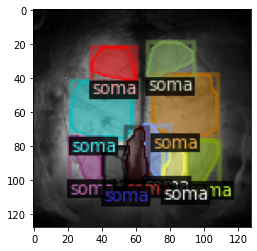

In [5]:
# plot
%matplotlib inline

for d in random.sample(mydata, 1):    
    im = cv2.imread(d["file_name"])
    
    v = Visualizer(im[:, :, ::-1],
                   metadata=mydata_metdata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

### Model configuration

In [6]:
# configuration file
cfg = configuration(num_classes=1,
                    train_output_path="C:/Users/admin/Desktop/test/out2",
                    min_image_size=125,
                    image_per_batch=1,
                    max_iter=15000, 
                    base_lr = 0.001,
                    model_weights=False, #"C:/Users/admin/Desktop/test/out/model_final.pth", # if you have another weights give that one
                    validation=True) # if you have validation turn it to True

### Model training

In [ ]:
# start training

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[10/12 16:44:24 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

step 1: reading imageJ ROIs
Total number of ROIs are: 10
step 2: loading video in h5 format
All keys; 
         GroupHierarchy.Groups.Datasets
step 3: transfering video to images
start saving images!


100%|█████████████████████████████████████| 1400/1400 [00:03<00:00, 448.26it/s]


step 4: creating annotation dictionary
step 5: converting to COCO style dataset
start to write COCO style dataset!


100%|█████████████████████████████████████| 4003/4003 [00:12<00:00, 329.36it/s]


step 1: reading imageJ ROIs
Total number of ROIs are: 10
step 2: loading video in h5 format
All keys; 
         GroupHierarchy.Groups.Datasets
step 3: transfering video to images
start saving images!


100%|█████████████████████████████████████| 1500/1500 [00:03<00:00, 491.45it/s]


step 4: creating annotation dictionary
step 5: converting to COCO style dataset
start to write COCO style dataset!


100%|█████████████████████████████████████| 4003/4003 [00:14<00:00, 269.26it/s]

[10/12 16:45:10 d2.data.build]: Removed 0 images with no usable annotations. 8000 images left.


[10/12 16:45:10 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    soma    | 80000        |
|            |              |
[10/12 16:45:10 d2.data.common]: Serializing 8000 elements to byte tensors and concatenating them all ...
[10/12 16:45:11 d2.data.common]: Serialized dataset takes 33.11 MiB
[10/12 16:45:11 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(125,), max_size=1333, sample_style='choice'), RandomFlip()]
[10/12 16:45:11 d2.data.build]: Using training sampler TrainingSampler


roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[10/12 16:45:12 d2.engine.train_loop]: Starting training from iteration 0


c:\users\admin\detectron2-windows\detectron2\layers\wrappers.py:226: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)
  return x.nonzero().unbind(1)


[10/12 16:45:26 d2.utils.events]:  eta: 1:06:56  iter: 19  total_loss: 4.601  loss_cls: 0.703  loss_box_reg: 0.286  loss_mask: 0.685  loss_rpn_cls: 2.677  loss_rpn_loc: 0.375  time: 0.2677  data_time: 0.3076  lr: 0.000020  max_mem: 850M
[10/12 16:45:31 d2.utils.events]:  eta: 1:08:18  iter: 39  total_loss: 2.534  loss_cls: 0.456  loss_box_reg: 0.504  loss_mask: 0.677  loss_rpn_cls: 0.626  loss_rpn_loc: 0.258  time: 0.2698  data_time: 0.0036  lr: 0.000040  max_mem: 875M
[10/12 16:45:37 d2.utils.events]:  eta: 1:07:24  iter: 59  total_loss: 1.949  loss_cls: 0.349  loss_box_reg: 0.366  loss_mask: 0.659  loss_rpn_cls: 0.300  loss_rpn_loc: 0.224  time: 0.2702  data_time: 0.0032  lr: 0.000060  max_mem: 875M
[10/12 16:45:43 d2.utils.events]:  eta: 1:07:23  iter: 79  total_loss: 1.846  loss_cls: 0.352  loss_box_reg: 0.394  loss_mask: 0.644  loss_rpn_cls: 0.215  loss_rpn_loc: 0.191  time: 0.2707  data_time: 0.0039  lr: 0.000080  max_mem: 875M
[10/12 16:45:48 d2.utils.events]:  eta: 1:07:53  ite

### Model prediction

In [3]:
# on single image

# save result's image
save_img = False

# get dir path to image
img_path = "I:/Sina/Medical report segmentation/publaynet/test_small/PMC1291385_00002.jpg"

# model weights (after training)
model_weights_path = "C:/Users/admin/Desktop/test/out/model_final.pth"

# path for saving final results
save_path = "C:/Users/admin/Desktop/test/test"

# get configuration file same as used during training
cfg = configuration(num_classes=5,
                    train_output_path="C:/Users/admin/Desktop/test/out",
                    min_image_size=440,
                    image_per_batch=1,
                    max_iter=150,
                    model_weights=model_weights_path,
                    validation=False)

# initialize main dataframe
df = pd.DataFrame()


df = predict_img(cfg=cfg, img_path=img_path, save_path=save_path,
                   img_save=save_img, df_save=False, score_thresh=0.3)

# save main dataframe
print("saving data frame!")
df.to_csv(os.path.join(save_path, "main_results") + ".csv", index=False)

TypeError: can only concatenate tuple (not "int") to tuple

In [7]:
# on multiple images

# save result's image
save_img = True

# get dir path to images
imgs_path = "I:/Sina/Medical report segmentation/publaynet/test_small"

# get images info
imgs = os.listdir(imgs_path)

# model weights (after training)
model_weights_path = "C:/Users/admin/Desktop/test/out/model_final.pth"

# path for saving final results
save_path = "C:/Users/admin/Desktop/test/test"

# get configuration file same as used during training
cfg = configuration(num_classes=5,
                    train_output_path="C:/Users/admin/Desktop/test/out",
                    min_image_size=240,
                    image_per_batch=1,
                    max_iter=150,
                    model_weights=model_weights_path,
                    validation=True)

# initialize main dataframe
df = pd.DataFrame()

# starting looping results
for img in imgs:
    df = df.append(predict_img(cfg=cfg, img_path=os.path.join(imgs_path, img), save_path=save_path,
                               img_save=save_img, df_save=False, score_thresh=0.7), ignore_index=True)

# save main dataframe
print("saving data frame!")
df.to_csv(os.path.join(save_path, "main_results") + ".csv", index=False)

TypeError: can only concatenate tuple (not "int") to tuple

In [11]:
a = [10, 10]

In [12]:
assert isinstance(a, tuple)

AssertionError: 